In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error
import seaborn as sns 
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)

In [16]:
print(df.dtypes)
df.describe()

region            int64
education         int64
jobtype           int64
cptype            int64
sales           float64
employees       float64
aversalary      float64
capital         float64
pros_encoded    float64
dtype: object
            region    education      jobtype       cptype        sales  \
count  3015.000000  3015.000000  3015.000000  3015.000000  2253.000000   
mean      0.764842     0.836153     0.482587     0.670315     1.609243   
std       0.808932     1.170736     0.499780     0.817098     3.502903   
min       0.000000     0.000000     0.000000     0.000000    -0.130200   
25%       0.000000     0.000000     0.000000     0.000000    -0.125200   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     2.000000     1.000000     1.000000     0.874800   
max       2.000000     5.000000     1.000000     2.000000    11.933775   

         employees   aversalary      capital  pros_encoded  
count  2482.000000  2149.000000  2303.0000

In [20]:
print("2 -> 수도권 : 서울, 인천, 세종, 경기")
print("1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산")
print("0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주")
region_counts = df['region'].value_counts()

total = df['region'].value_counts().sum()
for region, counts in enumerate(region_counts):
    print(f"{region} -> {counts} ({np.round(counts/total, 4)})")

2 -> 수도권 : 서울, 인천, 세종, 경기
1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
0 -> 1424 (0.4723)
1 -> 876 (0.2905)
2 -> 715 (0.2371)


### 상관계수 및 VIF 확인 & 가중치 감쇠를 통한 Selected feature 존재 여부 확인 (불균형 데이터셋)

<h5> Sales 값이 VIF 도 가장 크고, Sales-Employees, Sales-capital 사이 (+) 상관관계도 유의미하다고 도출 </h5>

1321 331
Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')
[ 0.01388677 -0.22147443 -0.09220308  0.01727753 -0.08614384 -0.03997324
 -0.02624263 -0.03510711]
[ 0.09001395  0.01805377 -0.27668691  0.0806614   0.00473234 -0.05177006
 -0.05361013 -0.45688356]
[-0.10390072  0.20342066  0.36888999 -0.09793893  0.0814115   0.0917433
  0.07985276  0.49199068]
Mean accuracy (train set) :  0.5163
Mean accuracy (test set) :  0.4441


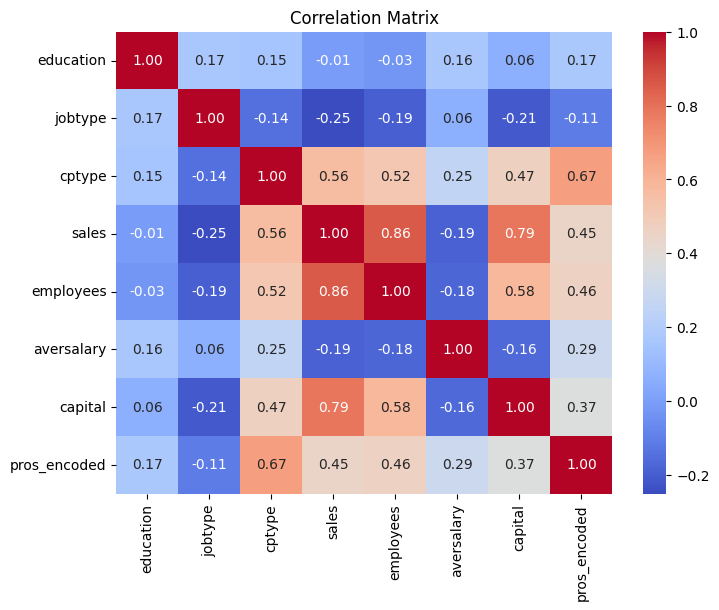

1.7006
1.619
3.3291
5.1123
4.4591
1.6113
2.7468
2.3063


In [33]:
# NaN 처리
df_dropna = df.dropna()
X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747, stratify=y)

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

# feature selection -> sales, employees, capital
print(df.columns)
for coef_set in linear.coef_:
    print(coef_set)

print("Mean accuracy (train set) : ", np.round(linear.score(X_train, y_train), 4)) 
print("Mean accuracy (test set) : ", np.round(linear.score(X_test, y_test), 4))

correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### Undersampling 을 적용하여 동일한 과정 반복  
=> 일반화 성능은 올라갔고, test score 는 거의 변동없음  
=> 그 외 VIF, 상관계수도 거의 변동없음

Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')
[-0.00223274 -0.23822568 -0.02835336  0.00167715 -0.07516296 -0.05152886
 -0.02026956 -0.0628788 ]
[ 0.07316766 -0.09115074 -0.3543893   0.11022609 -0.0312242   0.00492768
 -0.04191594 -0.34307551]
[-0.07093492  0.32937642  0.38274266 -0.11190324  0.10638716  0.04660118
  0.0621855   0.40595431]
Mean accuracy (train set) :  0.475
Mean accuracy (test set) :  0.4542


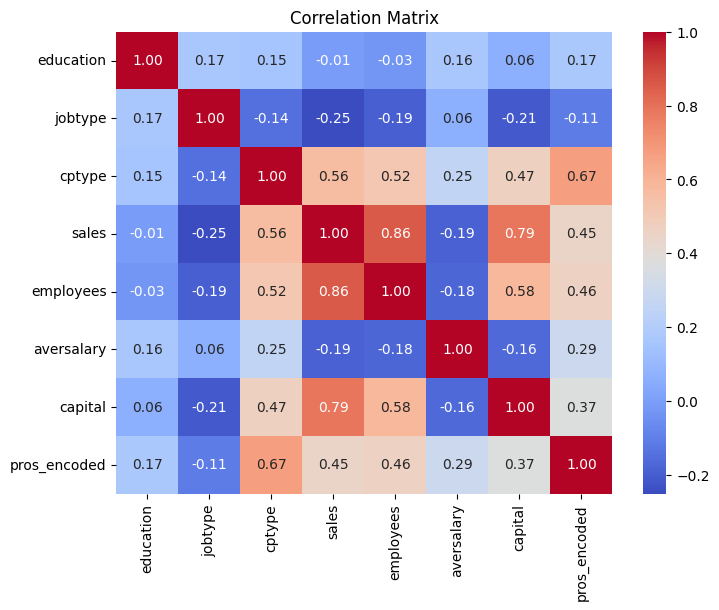

1.737
1.6676
3.2701
5.3599
4.614
1.594
3.0266
2.3104


In [35]:
# NaN 처리
df_dropna = df.dropna()

class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

df_dalanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_dalanced.reset_index(drop=True, inplace=True)

X = df_dalanced.iloc[:, 1:]
y = df_dalanced['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747, stratify=y)

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

# feature selection -> sales, employees, capital
print(df.columns)
for coef_set in linear.coef_:
    print(coef_set)

print("Mean accuracy (train set) : ", np.round(linear.score(X_train, y_train), 4)) 
print("Mean accuracy (test set) : ", np.round(linear.score(X_test, y_test), 4))

correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### GradientBoostingClassifier (불균형 데이터셋)

In [30]:
df_dropna = df.dropna()

print(df_dropna['region'].value_counts())

X = df_dropna.iloc[:, 1:]
y = df_dropna['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

clf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=0.2, 
                                 max_depth=1, 
                                 random_state=505).fit(X_train, y_train)
print(np.round(clf.score(X_test, y_test), 4))

region
0    780
1    440
2    432
Name: count, dtype: int64
0.4773


### GradientBoostingClassifier (UnderSampling 적용)

In [34]:
df_dropna = df.dropna()
# 클래스 별로 400개씩 무작위로 샘플링
class_0_sample = df_dropna[df_dropna['region'] == 0].sample(n=400, replace=False)
class_1_sample = df_dropna[df_dropna['region'] == 1].sample(n=400, replace=False)
class_2_sample = df_dropna[df_dropna['region'] == 2].sample(n=400, replace=False)

df_dalanced = pd.concat([class_0_sample, class_1_sample, class_2_sample])

df_dalanced.reset_index(drop=True, inplace=True)

X = df_dalanced.iloc[:, 1:]
y = df_dalanced['region']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=747)

clf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=0.2, 
                                 max_depth=1, 
                                 random_state=505).fit(X_train, y_train)

print(np.round(clf.score(X_test, y_test), 4))

0.4333


### 중소기업일 수록 회사정보가 등록되지 않았을 것(= 결측치로 수집되었을 것)이라고 가정  
 => 가정이 참이라면 결측치 자체로도 유의미한 정보를 가지게 된다.  
 => 가정이 참이라면 결측치를 drop 했을 경우 중소기업에 대한 행데이터가 다수 빠졌을 것  
 => 양질(?) 의 구인공고 지역별 분포 현황을 분석함에 있어서 '기업타입(대기업, 중견, 중소, ...)' 는 중요한 정보  
 => 최종결론은 가정이 참일 경우 "결측치를 drop 하면 예측과 분석에 불리해진다" 가 된다.  
<br></br>
지금까지 결측치는 모두 drop 처리하고 진행하였다. 앞으로의 과정은 다음과 같을 예정이다.
<ul>1 . 결측값이 존재하는 행에 대해 데이터 탐색과정을 거치고  </ul>
<ul>2. 결측값을 포함하여 학습이 가능한 Xgboost 를 통해 결측값을 포함하여 학습 및 예측을 수행  </ul>
<ul>3. 결측값을 제외한 채로 Xgboost 를 통해 학습 및 예측 수행  </ul>
<ul>4. 1~3 과정을 통해 최선의 데이터셋 (baseline) 을 설정하고 하이퍼 파라미터 튜닝 및 필요에 따라 앙상블 적용  </ul>

In [45]:
# df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)
nan_rows = df.isna().any(axis=1)
df_nan = pd.DataFrame(columns=df.columns)

for i in range(len(nan_rows)):
    if nan_rows[i]:
        row = df.iloc[i]  # NaN 값을 포함하는 행 선택
        df_nan = pd.concat([df_nan, pd.DataFrame([row], columns=df.columns)], ignore_index=True)


print(df_nan.describe())

df_nan.head()

C:\Users\user\AppData\Local\Temp\ipykernel_13916\445723291.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame([row], columns=df.columns)], ignore_index=True)


            region    education      jobtype       cptype       sales  \
count  1363.000000  1363.000000  1363.000000  1363.000000  601.000000   
mean      0.735143     0.781365     0.463683     0.462949    3.064883   
std       0.781291     1.153061     0.498862     0.770643    4.729794   
min       0.000000     0.000000     0.000000     0.000000   -0.130200   
25%       0.000000     0.000000     0.000000     0.000000   -0.127200   
50%       1.000000     0.000000     0.000000     0.000000    0.000000   
75%       1.000000     1.000000     1.000000     1.000000    5.933400   
max       2.000000     5.000000     1.000000     2.000000   11.933775   

        employees  aversalary     capital  pros_encoded  
count  830.000000  497.000000  651.000000   1363.000000  
mean     0.878127   -0.180477    2.734666     -0.094828  
std      2.655539    0.626951    4.614355      0.536420  
min     -0.209200   -1.521700   -0.113000     -0.500000  
25%     -0.203600   -0.565200   -0.110700     -0.500

,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
0,2.0,0.0,0.0,0.0,11.933775,9.892039,0.8261,NaN,0.95
1,2.0,0.0,1.0,1.0,11.055401,10.369383,NaN,NaN,0.40
2,2.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,0.05
3,2.0,1.0,1.0,1.0,1.371700,0.885500,1.5652,NaN,0.60
4,2.0,0.0,1.0,2.0,0.312000,-0.027200,NaN,5.8862,1.00


<h5> 대부분의 결측값은 중소기업에 해당함을 확인 </h5>

In [51]:
print("지역에 따른 결측값 분포: \n", df_nan['region'].value_counts())
print("회사 규모에 따른 결측값 분포: \n", df_nan['cptype'].value_counts())

지역에 따른 결측값 분포: 
 region
0.0    644
1.0    436
2.0    283
Name: count, dtype: int64
회사 규모에 따른 결측값 분포: 
 cptype
0.0    967
2.0    235
1.0    161
Name: count, dtype: int64


### 결측값을 포함하여 Xgboost classifier 학습